1. **Nombre: Allen Joseph Arroyo Garrido**
2. **Tarea 2 Deep Learning**
3. **Entrega 5 Octubre de 2024**

In [8]:
%matplotlib inline

# TAREA 2

**Adapted from:** [Nathan Inkawhich](https://github.com/inkawhich)

In this task, we will look at how to create a model for image classification, the impact of transfer learning using models pretrained on the 1000-class Imagenet dataset. The most efficient parameters for each architectures are likely to change, so you must look at the existing architecture and make custom adjustments for each model.

En esta tarea, veremos cómo crear un modelo para la clasificación de imágenes, el impacto del aprendizaje por transferencia utilizando modelos preentrenados en el conjunto de datos Imagenet de 1000 clases. Es probable que los parámetros más eficientes para cada arquitectura cambien, por lo que deberás fijarte en la arquitectura existente y realizar ajustes personalizados para cada modelo.


We will try to learn using a model **trained from scratch**, to do **feature extraction** by using only the last layer of a pre-trained network and only update the final layer weights using our data and label (i.e., using the CNN as a fixed feature extractor), and to **fine-tune** a pretrained model and update *all* of the model’s parameters for our task.


Intentaremos aprender usando un modelo **entrenado desde cero**, hacer **extracción de características**( **feature extraction**) usando sólo la última capa de una red preentrenada y sólo actualizar los pesos de la capa final usando nuestros datos y etiqueta (es decir, usando la CNN como un extractor de características fijo), y **ajustar**(**fine-tune**) un modelo preentrenado y actualizar *todos* los parámetros del modelo para nuestra tarea.


More information about transfer learning [in the CS231n class of Standford](https://cs231n.github.io/transfer-learning/) and in [Sebastian Ruder's blog post](https://ruder.io/transfer-learning/).

### Goal

The goals for you are to
* Fill up the code at different points where you have `# TODO`,
* Try different hyper-parameters of the models, different training and evaluation settings in order to answer the questions
* In the end you will have to upload an image of yours to test your model on it!    

Los objetivos son
* Rellenar el código en diferentes puntos donde tengas `# TODO`,
* Probar diferentes hiperparámetros de los modelos, diferentes configuraciones de entrenamiento y evaluación para responder a las preguntas.
* Al final tendrás que subir una imagen tuya para probar tu modelo en ella.    

### Data

We will use an Emotion Recognition dataset derived from FlickR30k. It is available at [this link](https://www.dcc.uchile.cl/~vbarrier/Flicker_data). It is composed of images that have been automatically tagged with several different emotions: `amusement, anger, awe, contentment, disgust, excitement, fear, sadness`.

Utilizaremos un conjunto de datos de Reconocimiento de Emociones derivado de FlickR30k. Está disponible en [este enlace](https://www.dcc.uchile.cl/~vbarrier/Flicker_data). Se compone de imágenes que han sido etiquetadas automáticamente con varias emociones diferentes: `diversión, enfado, asombro, satisfacción, asco, excitación, miedo, tristeza`.

Download the data and set them in your google drive. The ``model_name`` input is the name of the model you wish to use and must
be selected from this list:
```python
['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
```

Descarga los datos y colócalos en tu google drive. La entrada ``model_name`` es el nombre del modelo que desea utilizar y debe
ser seleccionado de esta lista:
``python
['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']

### Before Starting! Some tips on GPU and Google Colab

You will likely to run this code on Google Colab in order to use GPU ressources. If not, the code will take 60 times more to run!!  

Colab will disconnect you if you the training is too long. In order to prevent this, you can use this piece of code in the console of your browser:

```java
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```

See more [here](https://www.reddit.com/r/StableDiffusion/comments/xhhlp0/automatic1111_on_colab_how_to_keep_it_running/).

In [9]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import shutil
from google.colab import files, drive
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sn
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

INIT_PATH = '/content/drive/My Drive/'
print('INIT_PATH : {}'.format(INIT_PATH))

PyTorch Version:  2.4.1+cu121
Torchvision Version:  0.19.1+cu121
INIT_PATH : /content/drive/My Drive/


# El siguiente codigo descomprime el archivo Flicker_data.zip de Drive. **NO CORRER OTRA VEZ.**

In [10]:
# NO CORRER OTRA VEZ.
# El siguiente codigo descomprime el archivo Flicker_data.zip de Drive.
import zipfile

# Nueva ruta al archivo ZIP
INIT_PATH = '/content/drive/MyDrive/'
zip_path = os.path.join(INIT_PATH, 'Flicker_data.zip')

# Verifica si el archivo existe
if os.path.exists(zip_path):
    print("Archivo encontrado, descomprimiendo...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(INIT_PATH)  # descomprime el archivo en la carpeta de drive
else:
    print("Archivo no encontrado en:", zip_path)


Archivo encontrado, descomprimiendo...


### Inputs
   
The other inputs are as follows:
* ``num_classes`` is the number of classes in the dataset, which is 8 in our case
* ``batch_size`` is the batch size used for training and may be adjusted according to the capability of your machine, ``num_epochs`` is the number of training epochs we want to run,
* ``feature_extract`` is a boolean that defines if we are finetuning or feature extracting. If ``feature_extract = False``, the model is finetuned and all model parameters are updated. If ``feature_extract = True``, only the last layer parameters are updated, the others remain fixed
* `lr` which is the learning rate of the optimizer


Las otras entradas son las siguientes:
* ``num_classes`` es el número de clases en el conjunto de datos, que es 8 en nuestro caso.
* ``batch_size`` es el tamaño del lote utilizado para el entrenamiento y se puede ajustar de acuerdo a la capacidad de su máquina, ``num_epochs`` es el número de épocas de entrenamiento que queremos ejecutar,
* ``feature_extract`` es un booleano que define si estamos afinando o extrayendo características. Si ``feature_extract = False``, el modelo se ajusta y todos los parámetros del modelo se actualizan. Si ``feature_extract = True``, sólo se actualizan los parámetros de la última capa, los demás permanecen fijos.
* `lr` que es la tasa de aprendizaje del optimizador

In [11]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./Flicker_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "resnet50"

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 15

# learning rate of the optimizer
lr=0.001 # para el 3er experimento ocupé lr = 0.01 en vez de 0.001

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
# Marca para la extracción de características. Cuando es Falso, ajustamos todo el modelo.
# Cuando es Verdadero, solo actualizamos los parámetros de la capa reformada

feature_extract = False

# Flag for data augmentation. When True apply a random cropped, a random
#   flip on the training images, and a rotation.
# Bandera para el aumento de datos. Cuando es True aplica un recorte aleatorio, un flip en las imágenes de entrenamiento, y una rotación.
data_augmentation = True

# if we want to top-N results;
#   set an integer if want the top-3 results for example, set None if not wanted
topNresults = None

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
[here](https://pytorch.org/docs/master/torchvision/models.html).


Two options to load the data:
* Option 1: Download the dataset, and put it directly in your Google Drive that you can access through colab. **This is better as you do not need to download the data everytime you are intiating a new colab instance. You will also be able to save your best model!**
* Option 2: Download the dataset directly on the colab instance


Datos de carga
---------

Ahora que sabemos cuál debe ser el tamaño de entrada, podemos inicializar los datos
los conjuntos de datos de imágenes y los cargadores de datos. Tenga en cuenta que los modelos
preentrenados con los valores de normalización codificados, como se describe
[aquí](https://pytorch.org/docs/master/torchvision/models.html).


Dos opciones para cargar los datos:
* Opción 1: Descargar el conjunto de datos, y lo puso directamente en su Google Drive que se puede acceder a través de colab. **Esto es mejor ya que no necesita descargar los datos cada vez que inicie una nueva instancia de colab. También podrás guardar tu mejor modelo.
* Opción 2: Descargar el conjunto de datos directamente en la instancia colab

#### Option 1: Use the dataset already in my Google Drive(ocupe esta opción)

Here I am using as path of the project `'/content/drive/My Drive/DATASETS/deepemotion/'` where I should put the [dataset](https://users.dcc.uchile.cl/~vbarrier/Flicker_data/) `Flicker_data`. It means that I have it in my google drive under the path `'DATASETS/deepemotion/'`

#### Opción 1: Usar el dataset que ya está en mi Google Drive

Aquí estoy usando como ruta del proyecto `'/content/drive/My Drive/DATASETS/deepemotion/'` donde debería poner el [dataset](https://users.dcc.uchile.cl/~vbarrier/Flicker_data/) `Flicker_data`. Significa que lo tengo en mi google drive bajo la ruta `'DATASETS/deepemotion/'`.

In [12]:
if not os.path.isdir('/content/drive'):
  drive.mount('/content/drive')

#path_corpus = '/content/drive/My Drive/DATASETS/deepemotion/'
path_corpus = '/content/drive/My Drive/'
if data_dir[0] != "/":
  data_dir = os.path.join(path_corpus, data_dir)

print(f"Ruta final de los datos: {data_dir}")

Ruta final de los datos: /content/drive/My Drive/./Flicker_data


#### Option 2: Download the data directly here

In [ ]:
# download data, it generates temp.zip file
! wget https://users.dcc.uchile.cl/~vbarrier/Flicker_data/Flicker_data.zip -O temp.zip

# unzip data, it generates Flicker_data folder
! unzip /content/temp.zip

data_dir = "/content/Flicker_data"

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

**Model Training and Validation Code**

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.


Funciones auxiliares
----------------

Antes de escribir el código para ajustar los modelos, vamos a definir algunas
funciones de ayuda.

**Código de entrenamiento y validación de modelos**

La función ``train_model`` se encarga del entrenamiento y validación de un
de un modelo dado. Como entrada, toma un modelo PyTorch, un diccionario de
un diccionario de cargadores de datos, una función de pérdida, un optimizador
para entrenar y validar, y una bandera booleana para cuando el modelo es un
modelo inicial.
La función se entrena durante el número especificado de épocas y después de cada época ejecuta una validación completa. También realiza un seguimiento del modelo(en términos de precisión de validación) y, al final del entrenamiento
y, devuelve el modelo más eficaz. Después de cada época,  se imprimen las precisiones de entrenamiento y validación.

In [13]:
def update_lists_for_f1_score(preds, labels, target_true, predicted_true, correct_true, all_labels):
  """
  Need to be executed at every batch in order to update the lists target_true, predicted_true and correct_true.
  target = TP + FN
  predicted_true = TP + FP
  correct_true = TP
  """

  # iterating over all the classes
  for class_k in all_labels:
    predicted_classes = preds == class_k
    target_classes = labels == class_k
    target_true[class_k] += torch.sum(target_classes).float()
    predicted_true[class_k] += torch.sum(predicted_classes).float()
    correct_true[class_k] += torch.sum(
        (predicted_classes) * (target_classes)).float()
  return target_true, predicted_true, correct_true

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                   use_tqdm=False, name_model = 'best_model_no_feature_extraction.pt'):
    since = time.time()
    t0 = since

    #if topNresults: print('Top-{:d} results counted as good prediction'.format(topNresults))
    #val_acc_history = []

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to initialize the counters of the true
    dico_labels = image_datasets['val'].class_to_idx
    dico_labels_inverse = {v:k for k, v in dico_labels.items()}
    all_labels = dico_labels.values()
    dict_true_init = {idx_lab : 0 for idx_lab in all_labels}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # Set model to training/evaluate mode
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            target_true = dict_true_init.copy()
            predicted_true = dict_true_init.copy()
            correct_true = dict_true_init.copy()

            # Iterate over data.
            array_for_loop = dataloaders[phase]
            if use_tqdm or (epoch == 0): # training is slow at 1st epoch
              array_for_loop = tqdm(array_for_loop)
            for inputs, labels in array_for_loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # TODO
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # TODO
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # create predictions
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    # TODO
                    if phase == 'train':
                      loss.backward()
                      optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                target_true, predicted_true, correct_true = update_lists_for_f1_score(preds, labels.data,
                                                    target_true, predicted_true, correct_true, all_labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # calculating F1
            recall = []
            precision = []
            f1_score = []
            # At the end of the epoch
            for k_class in range(len(set(all_labels))):
                recall.append(correct_true[k_class] / target_true[k_class])
                precision.append(correct_true[k_class] / predicted_true[k_class])
                f1_score.append(2 * precision[k_class] * recall[k_class] / (precision[k_class] + recall[k_class]))

            epoch_f1 = np.mean([k.cpu().numpy() for k in f1_score])

            time_epoch = time.time()-t0
            print('{} Loss: {:.4f} Acc: {:.4f}  F1: {:.4f} in {:.0f}m {:.0f}s'.format(phase, epoch_loss, epoch_acc,
                                                                          epoch_f1, time_epoch // 60, time_epoch % 60))
            # write the F1 per label
            # if phase == 'val':
            if True:
                str_to_write = 'F1 : '
                for k, v in dico_labels.items():
                    str_to_write += "'{}' : {:.4f}, ".format(k, f1_score[v])
                print(str_to_write)

            t0 = time.time()

            # deep copy the model if best accuracy in this epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print('Best model saved')
                torch.save(model, 'temp_' + name_model)
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (val_acc_history, val_loss_history), (train_acc_history, train_loss_history)


#### Set Model Parameters’ .requires_grad attribute

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.

#### Establecer el atributo .requires_grad de los parámetros del modelo

Esta función de ayuda establece el atributo ``.requires_grad`` de los
parámetros en el modelo a False cuando estamos extrayendo características. En
defecto, cuando cargamos un modelo preentrenado todos los parámetros tienen
``.requires_grad=True``, lo que está bien si estamos entrenando desde cero
o ajuste fino. Sin embargo, si estamos extrayendo características y sólo queremos calcular gradientes para la capa recién inicializada, entonces queremos que todos los demás parámetros no requieran gradientes. Esto tendrá más sentido más adelante.



In [14]:
# si feature_extracting =True -> requires_grad=False

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initialize and Reshape the Networks


Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Ahora pasamos a la parte más interesante. Aquí es donde nos ocupamos de la remodelación de cada red.  Tenga en cuenta, esto no es un procedimiento automático y es único para cada modelo.  Recordemos que la capa final de un modelo CNN, que a menudo es una capa FC, tiene el mismo número de nodos que el número de clases de salida en el conjunto de datos. Dado que todos los modelos han sido preentrenados en Imagenet, todos tienen capas de salida de tamaño 1000, un nodo por cada clase. El objetivo aquí es remodelar la última capa para que tenga el mismo número de entradas que antes, Y para que tenga el mismo número de salidas que el número de clases del conjunto de datos. En las secciones siguientes veremos cómo modificar la arquitectura de cada modelo por separado. Pero antes, hay un detalle importante sobre la diferencia entre el ajuste fino y la extracción de características.

Al extraer características, sólo queremos actualizar los parámetros de la última capa, o dicho de otro modo, sólo queremos actualizar los parámetros de la capa o capas que estamos remodelando. Por lo tanto, no necesitamos calcular los gradientes de los parámetros que no estamos cambiando, así que por eficiencia establecemos el atributo .requires_grad a False. Esto es importante porque, por defecto, este atributo es True. Entonces, cuando inicializamos la nueva capa y por defecto los nuevos parámetros tienen ``.requires_grad=True`` por lo que sólo se actualizarán los parámetros de la nueva capa. Cuando estemos afinando podemos dejar todos los .required_grad's por defecto en True.




### Resnet

Resnet was introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). There are several variants of different sizes, including Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152, all of which are available from torchvision models. Here we use Resnet18, as our dataset is small and only has two classes. When we print the model, we see that the last layer is a fully connected layer as shown below:

Resnet se introdujo en el artículo [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). Hay varias variantes de diferentes tamaños, incluyendo Resnet18, Resnet34, Resnet50, Resnet101, y Resnet152, todos los cuales están disponibles en los modelos de torchvision. Aquí utilizamos Resnet18, ya que nuestro conjunto de datos es pequeño y sólo tiene dos clases. Cuando imprimimos el modelo, vemos que la última capa es una capa totalmente conectada, como se muestra a continuación:

```
   (fc): Linear(in_features=512, out_features=1000, bias=True)
```

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

Por lo tanto, debemos reinicializar ``model.fc`` para que sea una capa lineal con 512 características de entrada y 2 características de salida con:


```
   model.fc = nn.Linear(512, num_classes)
```

### Alexnet


Alexnet was introduced in the paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) and was the first very successful CNN on the ImageNet dataset. When we print the model architecture, we see the model output comes from the 6th layer of the classifier

Alexnet se introdujo en el artículo [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) y fue la primera CNN de gran éxito en el conjunto de datos ImageNet. Cuando imprimimos la arquitectura del modelo, vemos que la salida del modelo proviene de la 6ª capa del clasificador


```

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
```
To use the model with our dataset we reinitialize this layer as

Para utilizar el modelo con nuestro conjunto de datos reiniciamos esta capa como

```
   model.classifier[6] = nn.Linear(4096,num_classes)
```

### VGG

VGG was introduced in the paper [Very Deep Convolutional Networks for
Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf). Torchvision offers eight versions of VGG with various lengths and some that have batch normalizations layers. Here we use VGG-11 with batch normalization. The output layer is similar to Alexnet, i.e.


### VGG

VGG se introdujo en el artículo [Very Deep Convolutional Networks for
reconocimiento de imágenes a gran escala](https://arxiv.org/pdf/1409.1556.pdf). Torchvision ofrece ocho versiones de VGG con varias longitudes y algunas que tienen capas de normalización por lotes. Aquí utilizamos VGG-11 con normalización por lotes. La capa de salida es similar a Alexnet, es decir
```

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
```
Therefore, we use the same technique to modify the output layer

Por lo tanto, utilizamos la misma técnica para modificar la capa de salida

```

   model.classifier[6] = nn.Linear(4096,num_classes)
```

### Squeezenet


The Squeeznet architecture is described in the paper [SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size](https://arxiv.org/abs/1602.07360) and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:


La arquitectura de Squeeznet se describe en el artículo [SqueezeNet:
Precisión al nivel de AlexNet con 50 veces menos parámetros y un modelo de <0,5 MB
tamaño del modelo](https://arxiv.org/abs/1602.07360) y utiliza una estructura de salida
diferente a la de cualquiera de los otros modelos mostrados aquí. Torchvision tiene dos
versiones de Squeezenet, nosotros utilizamos la versión 1.0. La salida proviene de una capa convolucional 1x1
que es la primera capa del clasificador:
```

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    )
```

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

Para modificar la red, reiniciamos la capa Conv2d para tener un
mapa de características de salida de profundidad 2 como


```

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
```

### Densenet

Densenet was introduced in the paper [Densely Connected Convolutional
Networks](https://arxiv.org/abs/1608.06993). Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

Densenet se introdujo en el artículo [Densely Connected Convolutional
Networks] (https://arxiv.org/abs/1608.06993). Torchvision tiene cuatro
variantes de Densenet pero aquí sólo utilizamos Densenet-121. La capa de salida
es una capa lineal con 1024 características de entrada:


```
   (classifier): Linear(in_features=1024, out_features=1000, bias=True)

```

To reshape the network, we reinitialize the classifier’s linear layer as

Para remodelar la red, reiniciamos la capa lineal del clasificador como

```
   model.classifier = nn.Linear(1024, num_classes)
```

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.

Observe que muchos de los modelos tienen estructuras de salida similares, pero cada uno debe manejarse de forma ligeramente diferente.



**Además, compruebe la arquitectura del modelo impreso de la red remodelada y asegúrese de que el número de características de salida es el mismo que el número de clases del conjunto de datos**

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True) # cuando tiene use_pretrained=use_pretrained tira error.

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Creation Datasets and Dataloaders

Regarding Data Augmentation, use `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip`, and also `transforms.RandomRotation` to see which one works best

En cuanto al aumento de datos, utilice `transforms.RandomResizedCrop` y `transforms.RandomHorizontalFlip`, y también `transforms.RandomRotation` para ver cuál funciona mejor

In [16]:
def return_datasets_dataloaders(data_dir, input_size=224, angle_rotation=5, data_augmentation = True):
    """
    Create the datasets and dataloaders needed for the training
    """

    # apply data augmentation
    list_data_transform_data_aug = [
            # TODO. Luego modifcar para ver cual es mejor
            transforms.RandomResizedCrop(input_size),  #  Recorta la imagen de forma aleatoria y luego la redimensiona
            transforms.RandomHorizontalFlip(),         # Invierte la imagen horizontalmente con una probabilidad de 50%
            transforms.RandomRotation(angle_rotation), # Rota la imagen aleatoriamente
            transforms.ToTensor(),                                               #  transforms.ToTensor() Convierte las imágenes a tensores de pytorch
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   #   Normaliza los valores de los píxeles de la imagen para Imagenet
        ]
    # test without data_augmentation
    list_data_transform = [
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

    # Data augmentation and normalization for training
    # Just normalization for validation
    if data_augmentation:
        data_transforms = {
            'train': transforms.Compose(list_data_transform_data_aug),
            'val': transforms.Compose(list_data_transform),
        }
    else: # no data augmentation in this case
        data_transforms = {
            'train': transforms.Compose(list_data_transform),
            'val': transforms.Compose(list_data_transform),
        }


    print("Initializing Datasets and Dataloaders"+data_augmentation*" with data augmentation"+"...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    return image_datasets, dataloaders_dict

image_datasets, dataloaders_dict = return_datasets_dataloaders(data_dir, data_augmentation = data_augmentation)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders with data augmentation...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.


Ahora que la estructura del modelo es correcta, el paso final para el ajuste fino y la extracción de características es crear un optimizador que sólo actualice los parámetros deseados. Recordemos que después de cargar el modelo preentrenado, pero antes de remodelarlo, si ``feature_extract=True`` establecemos manualmente todos los atributos ``.requires_grad`` de los parámetros en False. Entonces los parámetros de la capa reinicializada tienen ``.requires_grad=True`` por defecto. Así que ahora sabemos que *todos los parámetros que tienen .requires_grad=True deben ser optimizados.* A continuación, hacemos una lista de dichos parámetros e introducimos esta lista en el constructor del algoritmo SGD.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.

Para verificar esto, comprueba los parámetros impresos para aprender. Al ajustar, esta lista debe ser larga e incluir todos los parámetros del modelo. Sin embargo, al extraer características, esta lista debe ser corta y sólo incluir los pesos y sesgos de las capas remodeladas.




In [17]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

# Reúne los parámetros a optimizar/actualizar en esta ejecución. Si estamos
# afinando(finetuning) estaremos actualizando todos los parámetros.

# Sin embargo,
# si estamos haciendo el método de extracción de características(feature extract),
# sólo actualizaremos los parámetros que acabamos de inicializar, es decir,
# los parámetros con requires_grad es True.

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.


Etapa de entrenamiento y validación
--------------------------------

Finalmente, el último paso es configurar la pérdida para el modelo, a continuación, ejecute el
la función de entrenamiento y validación para el número establecido de épocas.

**Nota**: **dependiendo del número de épocas, este paso puede tardar un poco en una CPU. Además, la tasa de aprendizaje por defecto no es óptima para todos los modelos, por lo que
para lograr la máxima precisión sería necesario ajustar para cada modelo
por separado**



# 1er experimento : feature_extract = False (con Fine-Tuning)


Este experimento fue el segundo en realizarse cronologicamente en $15$ epocas y $lr = 0.001$. Las estadisticas compactas son las siguientes:

1. Entrenamiento completado en : $84m \hspace{1mm} 12s$
2. Total de $29m\hspace{1mm} 9s$, y aproximadamente $3m \hspace{1mm} 50s$ por epoca.
3. Best val Acc: $0.616368$.

In [ ]:
# feature_extract = False , data_augmentation = False

name_model = 'best_model_'+'no_'*(not feature_extract)+'feature_extraction'+(data_augmentation)*'_data_augmentation'+'.pt'
# Train and evaluate
model_ft, hist_val, hist_train = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,
                             use_tqdm=False, name_model = name_model)
torch.save(model_ft, '{}/{}'.format(data_dir, name_model))
os.remove('temp_' + name_model)

Epoch 0/14
----------


100%|██████████| 331/331 [29:09<00:00,  5.29s/it]


train Loss: 1.2153 Acc: 0.5680  F1: 0.4637 in 29m 9s
F1 : 'amusement' : 0.7127, 'anger' : 0.1397, 'awe' : 0.6213, 'contentment' : 0.5892, 'disgust' : 0.5614, 'excitement' : 0.5063, 'fear' : 0.1005, 'sadness' : 0.4781, 


100%|██████████| 7/7 [00:52<00:00,  7.52s/it]


val Loss: 1.2262 Acc: 0.5422  F1: 0.5159 in 0m 53s
F1 : 'amusement' : 0.6818, 'anger' : 0.1918, 'awe' : 0.7000, 'contentment' : 0.4561, 'disgust' : 0.5895, 'excitement' : 0.6261, 'fear' : 0.3103, 'sadness' : 0.5714, 
Best model saved

Epoch 1/14
----------
train Loss: 0.9118 Acc: 0.6791  F1: 0.6098 in 3m 50s
F1 : 'amusement' : 0.8114, 'anger' : 0.3527, 'awe' : 0.7108, 'contentment' : 0.7020, 'disgust' : 0.7165, 'excitement' : 0.6235, 'fear' : 0.3448, 'sadness' : 0.6163, 
val Loss: 1.1388 Acc: 0.5678  F1: 0.5537 in 0m 3s
F1 : 'amusement' : 0.6415, 'anger' : 0.3117, 'awe' : 0.7048, 'contentment' : 0.5391, 'disgust' : 0.6022, 'excitement' : 0.5800, 'fear' : 0.4348, 'sadness' : 0.6154, 
Best model saved

Epoch 2/14
----------
train Loss: 0.7220 Acc: 0.7483  F1: 0.6915 in 3m 51s
F1 : 'amusement' : 0.8551, 'anger' : 0.4904, 'awe' : 0.7702, 'contentment' : 0.7741, 'disgust' : 0.7885, 'excitement' : 0.7016, 'fear' : 0.4536, 'sadness' : 0.6984, 
val Loss: 1.1242 Acc: 0.5831  F1: 0.5703 in 0m 3s

# 2do Experimento : feature_extract,data_augmentation = True,False (Sin fine-tuning en la extracción de características.)

Este experimento fue el primero en ejecutarse y se utilizaron $24$ epocas y $lr = 0.001$, esto antes de que el profesor escribiera en el foro.

Las estadisticas compactas son las siguientes:

1. Entrenamiento completado en :  $115m \hspace{1mm} 40s$
2. Total de $25m \hspace{1mm} 55s$, y aproximadamente $3m \hspace{1mm}40s$ por epoca
3. Best val Acc: $0.560102$.

In [ ]:
# feature_extract = True, data_augmentation = False


name_model = 'best_model_'+'no_'*(not feature_extract)+'feature_extraction'+(data_augmentation)*'_data_augmentation'+'.pt'

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,
                             use_tqdm=False, name_model = name_model)

torch.save(model_ft, '{}/{}'.format(data_dir, name_model))
os.remove('temp_' + name_model)

Epoch 0/24
----------


100%|██████████| 331/331 [25:54<00:00,  4.70s/it]


train Loss: 1.3183 Acc: 0.5445  F1: 0.4270 in 25m 55s
F1 : 'amusement' : 0.6920, 'anger' : 0.0692, 'awe' : 0.6220, 'contentment' : 0.5651, 'disgust' : 0.4998, 'excitement' : 0.4743, 'fear' : 0.0583, 'sadness' : 0.4350, 


100%|██████████| 7/7 [00:34<00:00,  4.89s/it]


val Loss: 1.3942 Acc: 0.4629  F1: 0.4158 in 0m 34s
F1 : 'amusement' : 0.5915, 'anger' : 0.0317, 'awe' : 0.6606, 'contentment' : 0.3866, 'disgust' : 0.5714, 'excitement' : 0.4146, 'fear' : 0.1538, 'sadness' : 0.5161, 
Best model saved

Epoch 1/24
----------
train Loss: 1.1273 Acc: 0.6043  F1: 0.5127 in 3m 40s
F1 : 'amusement' : 0.7482, 'anger' : 0.2029, 'awe' : 0.6539, 'contentment' : 0.6207, 'disgust' : 0.6411, 'excitement' : 0.5503, 'fear' : 0.1705, 'sadness' : 0.5142, 
val Loss: 1.3300 Acc: 0.5141  F1: 0.4756 in 0m 6s
F1 : 'amusement' : 0.6296, 'anger' : 0.0667, 'awe' : 0.7200, 'contentment' : 0.4727, 'disgust' : 0.5806, 'excitement' : 0.5362, 'fear' : 0.2373, 'sadness' : 0.5614, 
Best model saved

Epoch 2/24
----------
train Loss: 1.0912 Acc: 0.6150  F1: 0.5365 in 3m 41s
F1 : 'amusement' : 0.7568, 'anger' : 0.2426, 'awe' : 0.6618, 'contentment' : 0.6321, 'disgust' : 0.6567, 'excitement' : 0.5563, 'fear' : 0.2560, 'sadness' : 0.5296, 
val Loss: 1.3483 Acc: 0.5013  F1: 0.4605 in 0m 4s

#### Plot hist

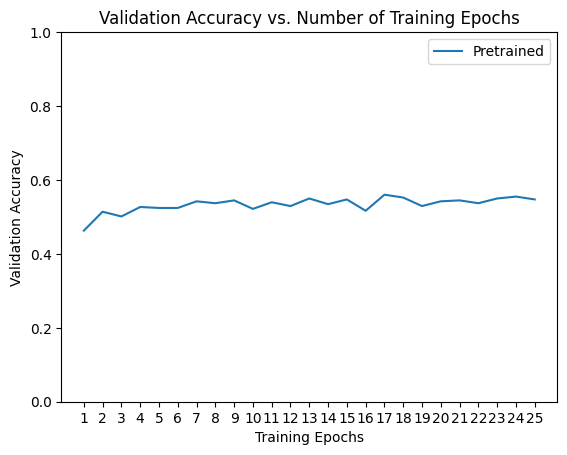

In [ ]:
# Esta fue la primera vez que plotee esta red, el 26 de septiembre, antes de la versión 2 de la tarea.

def plot_hist_v1(hist):
  """
  Plot the training curves of validation accuracy vs. number of training epochs
  """
  ohist = []

  ohist = [h.cpu().numpy() for h in hist]

  plt.title("Validation Accuracy vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Validation Accuracy")
  plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
  # plt.plot(range(1,num_epochs+1),shist,label="Scratch")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

plot_hist_v1(hist)

# Feature_extract, data_augmentation = False,True (Con fine-tuning y data augmentation.)

Este experimento fue el ultimo en realizarse cronologicamente en $15$ epocas y $lr = 0.01$(esto debido a que en colab con 0.001 se demoraba más de 3h sin terminar). Las estadisticas compactas son las siguientes:

1. Entrenamiento completado en : $61m \hspace{1mm} 33s$
2. Total de aproximadamente $10m$, y $4m$ por epoca.
3. Best val Acc: $0.616368$

In [18]:
# Feature_extract = False, data_augmentation = True

name_model_3 = 'best_model_'+'no_'*(not feature_extract)+'feature_extraction'+(data_augmentation)*'_data_augmentation'+'.pt'

# Train and evaluate
model_ft, hist_val, hist_train = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,
                             use_tqdm=False, name_model = name_model_3)

torch.save(model_ft, '{}/{}'.format(data_dir, name_model_3))
os.remove('temp_' + name_model_3)

Epoch 0/14
----------


100%|██████████| 335/335 [04:15<00:00,  1.31it/s]


train Loss: 1.3931 Acc: 0.5182  F1: 0.4329 in 4m 15s
F1 : 'amusement' : 0.6557, 'anger' : 0.1845, 'awe' : 0.5726, 'contentment' : 0.5523, 'disgust' : 0.4894, 'excitement' : 0.4269, 'fear' : 0.1418, 'sadness' : 0.4403, 


100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


val Loss: 1.6172 Acc: 0.4501  F1: nan in 0m 4s
F1 : 'amusement' : 0.5660, 'anger' : 0.3778, 'awe' : 0.5526, 'contentment' : 0.4211, 'disgust' : 0.5500, 'excitement' : 0.4118, 'fear' : nan, 'sadness' : 0.4681, 
Best model saved

Epoch 1/14
----------
train Loss: 1.2584 Acc: 0.5606  F1: 0.4866 in 3m 56s
F1 : 'amusement' : 0.6932, 'anger' : 0.2570, 'awe' : 0.6004, 'contentment' : 0.5813, 'disgust' : 0.5736, 'excitement' : 0.4850, 'fear' : 0.2157, 'sadness' : 0.4866, 
val Loss: 1.4646 Acc: 0.5166  F1: 0.5037 in 0m 5s
F1 : 'amusement' : 0.6019, 'anger' : 0.4909, 'awe' : 0.6610, 'contentment' : 0.3810, 'disgust' : 0.5682, 'excitement' : 0.5217, 'fear' : 0.3103, 'sadness' : 0.4941, 
Best model saved

Epoch 2/14
----------
train Loss: 1.1594 Acc: 0.5902  F1: 0.5183 in 3m 58s
F1 : 'amusement' : 0.7215, 'anger' : 0.2889, 'awe' : 0.6382, 'contentment' : 0.6068, 'disgust' : 0.5933, 'excitement' : 0.5141, 'fear' : 0.2572, 'sadness' : 0.5264, 
val Loss: 1.3072 Acc: 0.5473  F1: 0.5337 in 0m 6s
F1 : '

Dentro de la carpeta descomprimida Flicker_data en MyDrive vamos a tener los modelos cargados guardados como:

```
best_model_feature_extraction.pt
best_model_no_feature_extraction.pt
best_model_no_feature_extraction_data_augmentation.pt
```


In [25]:
def plot_hist_v1(hist):
  """
  Plot the training curves of validation accuracy vs. number of training epochs
  """
  ohist = []

  ohist = [h.cpu().numpy() for h in hist]

  plt.title("Validation Accuracy vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Validation Accuracy")
  plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
  # plt.plot(range(1,num_epochs+1),shist,label="Scratch")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

#plot_hist_v1(hist_val)

In [20]:
def plot_hist(hist_val, hist_train, num_epochs):
    """
    Plot the training and validation accuracy and loss curves on the same figure with two y-axes.
    """
    hist_val_acc, hist_val_loss = hist_val
    hist_train_acc, hist_train_loss = hist_train

    val_acc = [h.cpu().numpy() for h in hist_val_acc]
    val_loss = [h for h in hist_val_loss]
    train_acc = [h.cpu().numpy() for h in hist_train_acc]
    train_loss = [h for h in hist_train_loss]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot accuracy on the primary y-axis
    ax1.set_xlabel('Training Epochs')
    ax1.set_ylabel('Accuracy', color='blue')
    ax1.plot(range(1, num_epochs + 1), val_acc, label="Validation Accuracy", linestyle='-', marker='o', color='blue')
    ax1.plot(range(1, num_epochs + 1), train_acc, label="Training Accuracy", linestyle='-', marker='x', color='cyan')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim([0, 1])  # Accuracy range

    # Create a secondary y-axis for loss
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Loss', color='red')
    ax2.plot(range(1, num_epochs + 1), val_loss, label="Validation Loss", linestyle='--', marker='o', color='red')
    ax2.plot(range(1, num_epochs + 1), train_loss, label="Training Loss", linestyle='--', marker='x', color='orange')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add legends
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.title("Accuracy and Loss vs. Number of Training Epochs")
    plt.xticks(np.arange(1, num_epochs + 1, 1.0))

    fig.tight_layout()  # To make sure everything fits without overlap
    plt.grid(True)
    plt.show()

#plot_hist(hist_val, hist_train, num_epochs=15)

Si deseo ocupar los 3 modelos guardados en la carpeta de drive.

```
# Ruta del modelo
model_path = os.path.join(data_dir, 'best_model_feature_extraction.pt')

# (Esto en un momento lo tuve que realizar porque perdí la opción de colab de ocupar una GPU)
# Carga el modelo mapeandolo a la CPU, antes fue hecho en una GPU

model_feature_extraction = torch.load(model_path, map_location=torch.device('cpu'))

# Si no ocupar en la linea de arriba model = torch.load(model_path)
model_feature_extraction.eval()
```



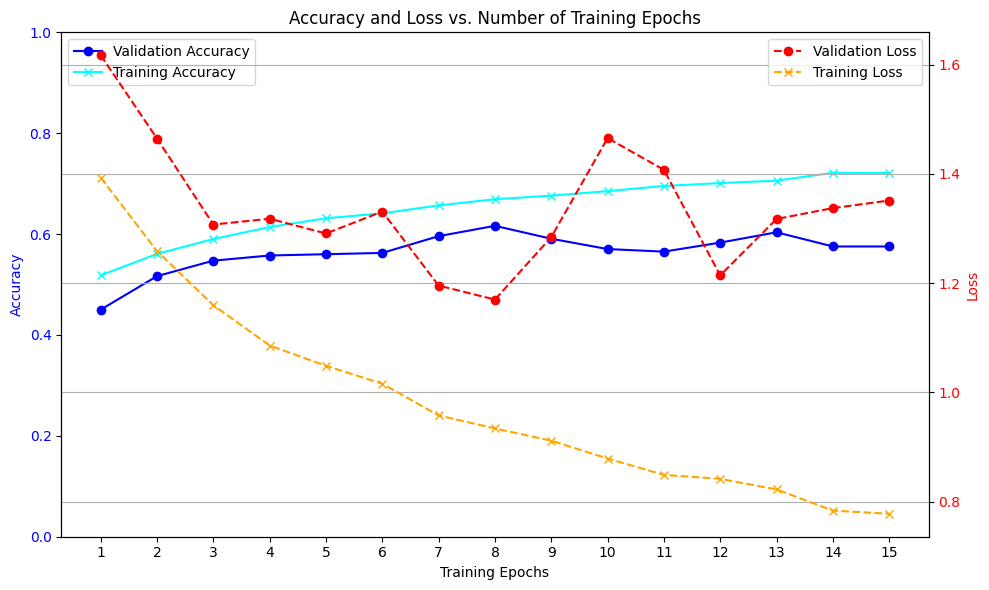

In [21]:
# Para best_model_no_feature_extraction_data_augmentation.pt

plot_hist(hist_val, hist_train, num_epochs=15)

# Some visualizations

We keep one model under the name `'fine_tune_total_best_accuracy.pt'` that obtained the scores below so that we can check it's F1 score.

Let's have a look at the model's predictions with
* the confusion matrix to see between which class is the confusion
* the top-N predictions to see if the model predict in which position it predicts the right class. It is important as emotion can be multi-class and are subjectives
* A aggregation of the emotions regarding their valence (positiveness)


Mantenemos un modelo bajo el nombre `'fine_tune_total_best_accuracy.pt'` que obtuvo las puntuaciones de abajo para que podamos comprobar su puntuación F1.

Echemos un vistazo a las predicciones del modelo con
* la matriz de confusión para ver entre qué clase está la confusión
* las predicciones top-N para ver si el modelo predice en qué posición predice la clase correcta. Es importante ya que la emoción puede ser multiclase y son subjetivas
* Una agregación de las emociones con respecto a su valencia (positividad).

In [27]:
def calc_preds_with_topN(outputs, y_true, N=3):
    """
    Put the prediction as the GT if the GT is in the top-N predictions of the model
    """

    preds_sorted = torch.argsort(outputs, dim = 1, descending = True)

    # bool_preds is true if the prediction is in the top-N
    bool_preds = preds_sorted[:,0] == y_true
    for i in range(1, N):
      bool_preds += preds_sorted[:,i] == y_true

    y_hat = (~bool_preds)*preds_sorted[:,0] + bool_preds*y_true

    return y_hat


def return_y(model, dataloaders, phase='val', topNresults=None):

    '''
    TODO
    Función para devolver las etiquetas predichas y verdaderas del modelo durante la inferencia.

    Args:
    model: El modelo entrenado a evaluar.
    dataloaders: Un diccionario que contiene cargadores de datos para diferentes fases (por ejemplo, 'train', 'val', 'test').
    phase: La fase que se utilizará para la evaluación (por defecto es 'val').
    topNresults: Si se proporciona, la función devolverá las N mejores predicciones; de lo contrario, devuelve la predicción más alta.

    Devuelve:
    y_hat: Una lista de etiquetas predichas.
    y_true: Una lista de etiquetas verdaderas.
    '''

    y_hat = []  # Initialize an empty list to store predicted labels.
    y_true = []  # Initialize an empty list to store true labels.

    # Iterate over the batches of data in the specified phase (e.g., 'val').
    for inputs, labels in dataloaders[phase]:

        # Move the input and label data to the specified device (e.g., GPU).
        # Mover los datos de entrada y etiqueta al dispositivo especificado (por ejemplo, GPU).
        # TODO
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Desactivar el calculo del gradiente durante la inferencia para ahorrar memoria y computacion (con bucle)
        # Disable gradient calculation during inference to save memory and computation (with loop)
        # TODO
        set_parameter_requires_grad(model, True) # Si es True lo desactiva.

        # Realizar una pasada hacia adelante a través del modelo para obtener los resultados.
        # Perform a forward pass through the model to get the outputs.
        # TODO
        model.eval()
        # inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        # If topNresults is specified, calculate predictions using (or not) top N probabilities using the outputs
        # (regarding the value of the boolean variable topNresults)
        # Si se especifica topNresults, calcula las predicciones usando (o no) las probabilidades top N usando las salidas
        # (con respecto al valor de la variable booleana topNresults)
        # TODO
        if topNresults is not None:
          preds = calc_preds_with_topN(outputs, labels, topNresults)

        # Anexar las predicciones y las etiquetas verdaderas a sus respectivas listas despues de moverlas a la CPU.
        # Append the predictions and the true labels to their respective lists after moving them to the CPU.
        for pred, label in zip(preds, labels):
            y_hat.append(pred.cpu())
            y_true.append(label.cpu())

    # Return the lists of predicted and true labels.
    return y_hat, y_true


def print_conf_mat_topN(model, dataloaders, all_labels_names, show_print=False,
                        phase = 'val', topNresults=None, binary_classif = False,
                       positive_classes = [0, 2, 3, 5]):
    """
    Allow to directly print the confusion matrix with the top-N prediction.
    Also print the associated F1.
    The classes [0, 2, 3, 5] are the positive emotions
    """
    y_hat, y_true = return_y(model, dataloaders, phase = 'val', topNresults=topNresults) # lo cambié por topNresults=None

    if binary_classif:
        y_hat = [k in positive_classes for k in y_hat]
        y_true = [k in positive_classes for k in y_true]
        all_labels_names = ['negative', 'positive']

    # simple visualization
    if show_print: print(confusion_matrix(y_true, y_hat))

    # fancy visualization using seaborn
    df_cm = pd.DataFrame(confusion_matrix(y_true, y_hat), index = all_labels_names,
                      columns = all_labels_names)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

    # Print the F1 for every class
    PRINT_F1 = True
    if PRINT_F1:
        str_to_write = 'F1 : global {}, '.format(f1_score(y_true, y_hat, average='macro'))
        for labn, fs in zip(all_labels_names, f1_score(y_true, y_hat, average=None)):
            str_to_write += "'{}' : {:.4f}, ".format(labn, fs)
        print(str_to_write)

In [31]:
# Extraemos best_model_no_feature_extraction_data_augmentation.pt de Drive.

model_path = os.path.join(data_dir,'best_model_no_feature_extraction_data_augmentation.pt')

model_no_feature_extraction_data_augmentation = torch.load(model_path)
model_no_feature_extraction_data_augmentation.eval()


<ipython-input-31-816a90d80f0d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_no_feature_extraction_data_augmentation = torch.load(model_path)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
# Acá tengo errores que no sé como arreglar para las matrices de confusion.

best_model = model_no_feature_extraction_data_augmentation

print_conf_mat_topN(best_model, dataloaders_dict,
               all_labels_names=image_datasets['val'].class_to_idx.keys(),
               topNresults=None, binary_classif=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


UnboundLocalError: local variable 'preds' referenced before assignment

In [ ]:
print_conf_mat_topN(best_model, dataloaders_dict,
               all_labels_names=image_datasets['val'].class_to_idx.keys(),
               topNresults=None, binary_classif=False)

In [ ]:
print_conf_mat_topN(best_model, dataloaders_dict,
               all_labels_names=image_datasets['val'].class_to_idx.keys(),
               topNresults=2, binary_classif=False)

In [ ]:
# To keep my best temp model, I need to put it on Google Drive, otherwise it's lost when I close colab
# Para conservar mi mejor modelo temporal, necesito ponerlo en Google Drive, de lo contrario se pierde cuando cierro Colab.

import shutil
shutil.copy('{}/{}'.format(data_dir, name_model), '{}/best_accuracy_{}'.format(path_drive_to_store_model, name_model))

NameError: name 'data_dir' is not defined

## Preguntas

* Que pienses de la matriz de confusion?
* Porque hace sentido de mirar la accuracy topN?

## Respuestas

**No pude graficar la matriz de confusión, hace sentido de mirar la accuracy topN porque el modelo puede entregar multiples opciones para reconocer emociones en una foto, por ejemplo en las imagenes de abajo. Queremos ver si la respuesta correcta(o más correcta) esté entre las N opciones más probables**

### Test on our own images !

Funny test

In [35]:
# Load the best_model
best_model = torch.load('{}/fine_tune_total_best_accuracy.pt'.format(data_dir))

def show_predictions(best_model, verbose=False):
    """
    Upload an image and look at the predictions
    """
    # Get the image
    uploaded = files.upload()

    if len(uploaded.keys()) > 1:
      for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
    elif len(uploaded.keys()) == 1:
      fn = list(uploaded.keys())[0]
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    else:
      print('Error: file not uploaded')

    im = Image.open(fn)
    width, height = im.size

    ratio_resize = 500./width # so it becomes "more or less" like an image of the corpus of size 500*390

    # If Resnet, input_size = 224
    input_size = 224

    # Preprocess the image
    img_preproc = transforms.Compose([
            transforms.Resize([int(width*ratio_resize), int(height*ratio_resize)]),
            # transforms.RandomResizedCrop(input_size),
            # transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    img_input = img_preproc(im)

    if verbose: print(img_input.shape)

    # Calculate outputs
    output_resnet = best_model(img_input.unsqueeze(0).cuda())[0]
    preds = torch.nn.functional.softmax(output_resnet, dim=0)

    # Show images and results
    dico_labels = image_datasets['val'].class_to_idx
    str_to_write = "Predictions:\n"

    # to sort them from the most to the least probable
    order_descending = np.argsort([k.cpu().detach().numpy() for k in preds])[::-1]

    list_items = list(dico_labels.items())
    # for label, label_idx in dico_labels.items()[order_descending]:
    for idx_order in order_descending:
          label, label_idx = list_items[idx_order]
          str_to_write += "'{}' : {:.2f}\n".format(label, 100*preds[label_idx])
    print(str_to_write)

    plt.imshow(np.asarray(im))

<ipython-input-35-4e224c831e38>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('{}/fine_tune_total_best_accuracy.pt'.format(data_dir))
/usr/local/l

Saving IMG_7584.jpg to IMG_7584.jpg
User uploaded file "IMG_7584.jpg" with length 6507256 bytes
Predictions:
'excitement' : 96.46
'amusement' : 1.95
'contentment' : 1.04
'anger' : 0.52
'disgust' : 0.01
'awe' : 0.01
'sadness' : 0.01
'fear' : 0.00



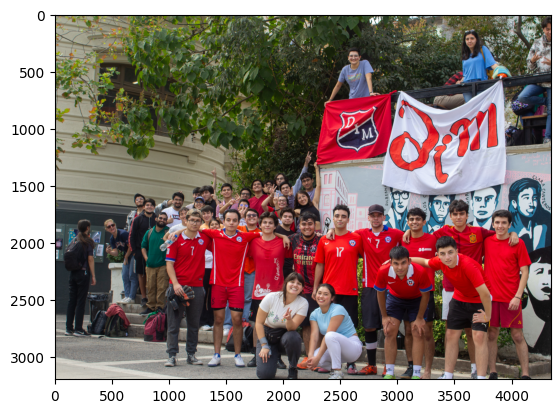

In [36]:
show_predictions(best_model)

Saving IMG_6955.jpg to IMG_6955.jpg
User uploaded file "IMG_6955.jpg" with length 570679 bytes
Predictions:
'awe' : 36.34
'sadness' : 30.31
'contentment' : 10.99
'fear' : 9.28
'disgust' : 6.00
'amusement' : 2.57
'anger' : 2.42
'excitement' : 2.10



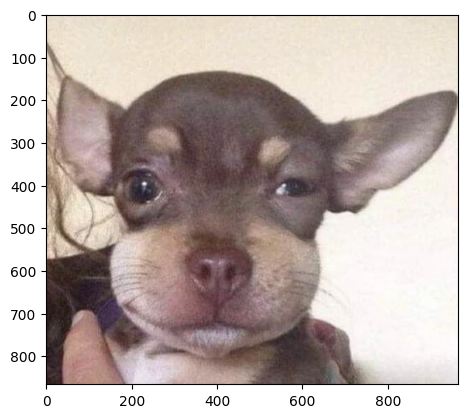

In [42]:
show_predictions(best_model)

Saving IMG_6895.jpg to IMG_6895.jpg
User uploaded file "IMG_6895.jpg" with length 178084 bytes
Predictions:
'contentment' : 32.32
'anger' : 30.11
'excitement' : 16.62
'disgust' : 6.59
'awe' : 6.53
'fear' : 3.93
'sadness' : 3.16
'amusement' : 0.74



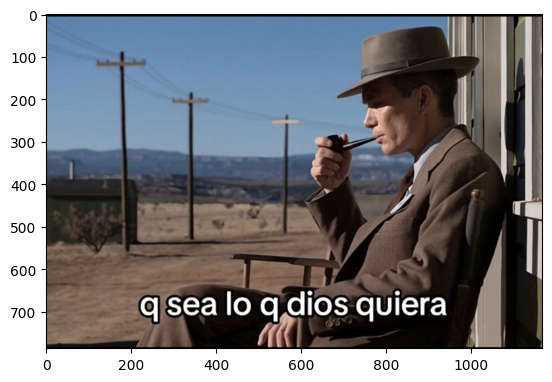

In [43]:
show_predictions(best_model)

Saving PHOTO-2024-10-05-22-06-04.jpg to PHOTO-2024-10-05-22-06-04.jpg
User uploaded file "PHOTO-2024-10-05-22-06-04.jpg" with length 91346 bytes
Predictions:
'contentment' : 52.56
'sadness' : 17.20
'awe' : 15.11
'anger' : 3.76
'fear' : 3.64
'amusement' : 3.52
'excitement' : 2.27
'disgust' : 1.94



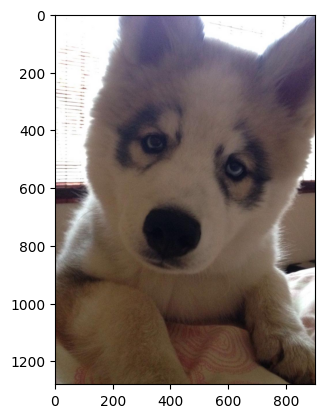

In [44]:
show_predictions(best_model)

Saving PHOTO-2024-10-05-22-06-37.jpg to PHOTO-2024-10-05-22-06-37.jpg
User uploaded file "PHOTO-2024-10-05-22-06-37.jpg" with length 104422 bytes
Predictions:
'contentment' : 51.19
'excitement' : 18.46
'anger' : 9.32
'fear' : 7.20
'awe' : 6.53
'amusement' : 5.43
'sadness' : 1.04
'disgust' : 0.83



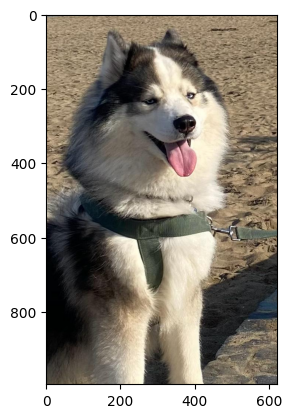

In [45]:
show_predictions(best_model)

# Preguntas

## Qué es un modelo pre-entrenado? Qué significa fine-tunear un modelo?

Un modelo pre-entrenado es una "red" la cual a sido entrenada anteriormente al aprendizaje como tal sobre un conjunto de datos, por ejemplo con datasets de imagenes uno puede utilizar Imagenet. Fine-tunear un modelo es no realizar extraccion de caracteristicas (feature_extract = False en el caso de esta tarea), esto quiere decir que estaremos actualizando(reentrenado) **todos los parametros** (full Fine-tunear)de la red, si queremos realizar los experimentos sin Fine-tunear(full Fine-tunear) se utiliza feature_extract = True , por lo que solo se actualizan los parámetros de la última capa.

Más detalles en la penultima pregunta.


## Cuáles son las diferencias principales entre entrenar un modelo desde cero y usar Transfer Learning?

El Transfer Learning consiste principalmente en trabajar con redes ya pre-entrenadas en un dataset standar más grande para luego mejorarla en el dataset de trabajo individual más especfico, con entrenar el modelo desde cero solo trabajariamos con el conjunto de datos especifico del problema. Se supone que transfer learning debería mejorar el rendimiento en comparación del modelo desde cero pues se espera que los modelos generalicen mejor si aprenden caracteristicas(feature) en conjuntos de datos más grandes(más diversos) y posiblemente disminuya el tiempo de entrenamiento.


## Que pasa con las curvas de aprentizaje cuando utilizamos representaciones viniendo de un modelo ya pre-entrenado?

Se debería esperar que el modelo tenga una mejora rapida al inicio, pues en el pre-entrenamiento varias de las características útiles ya se encontraran presentes en las capas que queramos congelar o ajustar, entonces el modelo necesitará ajustar menos parámetros por capa. A modo de resumen el modelo aprovecha las caracterisitcas ya aprendidas por lo que la convergencia debería resultar más rapida, es decir, el modelo aprende más rapido.



## A qué hace referencia Layer Freezing? ¿Cuáles podrían ser las ventajas de hacer esto?

Cuando pre-entrenamos un modelo con un dataset grande (Imagenet por ejemplo), hay ciertas caracteristicas(pesos,parametros) que quizás no queremos que nuevamente se actualizen y re-entrenen, por lo que "congelamos" ciertas capas profundas, podríamos hasta incluso congelar todas las capas y solo hacer que se modifque la ultima, este congelamiento en rigor quiere decir que cuando se efectue una actualización de los pesos(backpropagation) en el entrenamiento, en estas capas no se van a modificar.

Debido a que se congelan ciertas capas, el entrenamiento total puede ser más rapido y si se congelan las capas iniciales la convergencia a un minimo local(global) puede ser más efectivo pues estamos enfocando el aprendizaje en una cantidad de capas que son más importantes a actualizar.



## Cuales son las differencias entre extractar los atributos y fine-tunear la ultima capa o fine-tunear todos los parametros del red? Que pasa con las curvas de apprentizaje?

Según clases extraer caracteristicas(Feature Extraction), consiste en congelar todas las capas del modelo entrenado previamente, utilizándolo como extractor de características. Y se agregan nuevas capas de clasificador en la parte superior y se entrenan solo estas capas. Se utiliza cuando el conjunto posterior al pre-entreno es pequeño y no se requieran cambios importantes en el modelo. Mientras que fine-tunear tiene dos opcciones :

1. Fine-tuning(general)
2. Full-Fine-tuning

En ambos se ajusta el modelo en los nuevos datos, en el Fine-tuning(general) se puede
1. Entrenar nuevamente todas las capas
2. Entrenar nuevamente solo las capas más profundas relacionadas con tareas específicas(congelar(freezing ) las capas iniciales)
3. Entrenar otra vez las capas profundas y descongelar(unfreezing) gradualmente las capas iniciales.

Mientras que Full-Fine-tuning se vuelve a entrenar siempre todas las capas, donde previamente se descongelan todas las capas, luego y se vuelven a entrenar. Es utilizado generalmente, por ejemplo en el Full-Fine-tuning, cuando el nuevo conjunto de datos es más grande,complejo, especifico o cuando las tareas(task) son muy diferentes.

## Cual es el efecto de la aumentacion de datos(data augmentation)? Como se puede ver? Que pasa con las curvas de aprentizaje?

Su objetivo general del data augmentation es mejorar la generalización del modelo a la vez de reducir el sobreajuste, por ejemplo uno puede mejorar la diversidad del dataset, esto al aplicar transformaciones como rotación,recorte, escalamiento, etc dependiendo de cada conjunto de imagenes a trabajar. Las curvas de aprendizaje pueden ser más estables y entregar resultados más robustos. Algunas desventajas de utilizar este metodo es aumentar el tiempo de entrenamiento de la red, estar ocupando transformaciones no adecuadas que empeoran el aprendizaje, posible confusión entre clases.
